In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np

X = np.random.rand(100, 4)

def minkowski(X):
    return np.sum(X[:,1:]**2, axis=1) - X[:,0]**2

# Compute timelike dim

t = np.sqrt(np.sum(X**2, axis=1) + 1)

X_t = np.column_stack((t, X))

minkowski(X_t)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [50]:
# Import mnist, split, standard scale, and run hdt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()

def phi(X):
    """Prepend 1 to each row"""
    return np.column_stack((np.ones(X.shape[0]), X))

/home/phil/mambaforge/envs/hdt/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [28]:
# from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.tree_torch import HyperbolicDecisionTreeClassifier

hdt = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=True, angle_midpoint_method="bisect")

In [29]:
%%prun

# prun with no optimizations

hdt.fit(phi(X_train.values[:, :100]), y_train)

ValueError: too many dimensions 'str'

In [32]:
None == "balanced"

False

In [24]:
%%prun

# prun with np.searchsorted replaced

hdt.fit(phi(X_train.values[:, :100]), y_train)

100%|██████████| 100/100 [00:00<00:00, 327.20it/s]

         1374200 function calls (1374180 primitive calls) in 45.357 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    72443   21.028    0.000   36.571    0.001 tree.py:66(_get_probs)
    72451   15.514    0.000   15.514    0.000 {method 'argmax' of 'numpy.ndarray' objects}
    24152    4.342    0.000    4.342    0.000 tree.py:263(_dot)
     15/1    1.215    0.081   44.856   44.856 tree.py:100(_fit_node)
    24145    0.966    0.000   38.136    0.002 tree.py:83(_information_gain)
        1    0.435    0.435    0.435    0.435 managers.py:1741(_interleave)
    24152    0.378    0.000    4.720    0.000 tree.py:276(_get_split)
    96581    0.260    0.000    0.260    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      708    0.232    0.000    0.232    0.000 {method 'sort' of 'numpy.ndarray' objects}
      700    0.224    0.000    0.493    0.001 hyperbolic_trig.py:76(get_candidates)
    72435    0.184    0.000   37.161    0.00

In [25]:
%%prun

# run the big boy

hdt.fit(phi(X_train.values), y_train)

100%|██████████| 784/784 [00:48<00:00, 16.18it/s]

         58243242 function calls (58243222 primitive calls) in 1009.594 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2538794  548.855    0.000  548.855    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
   846269  129.882    0.000  129.882    0.000 tree.py:261(_dot)
     15/1  111.932    7.462 1008.199 1008.199 tree.py:98(_fit_node)
   846262  105.788    0.000  737.879    0.001 tree.py:81(_information_gain)
  2538794   56.314    0.000  610.436    0.000 tree.py:66(_get_probs)
   846269   12.362    0.000  142.244    0.000 tree.py:274(_get_split)
  3385049    9.319    0.000    9.319    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  2538786    6.884    0.000  631.779    0.000 tree.py:74(_gini)
  3385048    5.642    0.000   18.392    0.000 fromnumeric.py:71(_wrapreduction)
  2538786    2.949    0.000   14.165    0.000 fromnumeric.py:2177(sum)
     5496    2.467    0.000    2.467    0.000 {method 'sort' of 'nump

In [36]:
%%prun

# version without searchsorted - way slower, stopped

hdt.fit(phi(X_train.values), y_train)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (784,) + inhomogeneous part.

In [28]:
from hyperdt.tree_torch import HyperbolicDecisionTreeClassifier as HyperbolicDecisionTreeClassifierTorch

hdt_torch = HyperbolicDecisionTreeClassifierTorch(max_depth=3, skip_hyperboloid_check=True, angle_midpoint_method="bisect")

In [32]:
import torch

X_torch, y_torch = torch.tensor(X_train.values.astype(np.float32)), torch.tensor(y_train.values.astype(np.int64))

In [39]:
%%prun

# torch version

hdt_torch.fit(torch.tensor(phi(X_torch)), y_torch)

100%|██████████| 784/784 [01:20<00:00,  9.72it/s]


NameError: name 'np' is not defined

In [12]:
import torch

In [20]:
from hyperdt.tree_torch import HyperbolicDecisionTreeClassifier as HDTCTorch

hdt = HDTCTorch()

In [21]:
from hyperdt.toy_data import wrapped_normal_mixture

X, y = wrapped_normal_mixture()
X = torch.Tensor(X)
y = torch.Tensor(y)

In [23]:
hdt.fit(X, y)

100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


HyperbolicDecisionTreeClassifier()

HyperbolicDecisionTreeClassifier()

In [2]:
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere

h = Hyperboloid(2)
s = Hypersphere(2)

In [4]:
import numpy as np

In [12]:
results = {}
curvs = [0.25, 0.5, 1]
# curvs = [1]

# Hyperboloid
for k in curvs:
    X_tangent = np.random.normal(size=(1_000_000, 2))

    # pre-adjust for curvature
    X_tangent *= np.sqrt(k)

    # prepend 1 to make it a tangent plane vector
    X_tangent = np.column_stack((np.zeros(X_tangent.shape[0]), X_tangent))

    # exp map at origin
    X_manifold = h.metric.exp(X_tangent, np.array([1., 0., 0.,]))

    # Get distances to origin
    dists = h.metric.dist(X_manifold, np.array([1., 0., 0.,]))

    results[-k] = np.arccosh(np.cosh(dists) / np.sqrt(k))
    # results[-k] = dists

# Euclidean
X_tangent = np.random.normal(size=(1_000_000, 2))
results[0] = np.linalg.norm(X_tangent, axis=1)

# Hypersphere
for k in curvs:
    X_tangent = np.random.normal(size=(1_000_000, 2))

    # pre-adjust for curvature
    X_tangent *= np.sqrt(k)

    # prepend 1 to make it a tangent plane vector
    X_tangent = np.column_stack((np.zeros(X_tangent.shape[0]), X_tangent))

    # exp map at origin
    X_manifold = s.metric.exp(X_tangent, np.array([1., 0., 0.,]))

    # Get distances to origin
    dists = s.metric.dist(X_manifold, np.array([1., 0., 0.,]))

    results[k] = dists / np.sqrt(k)

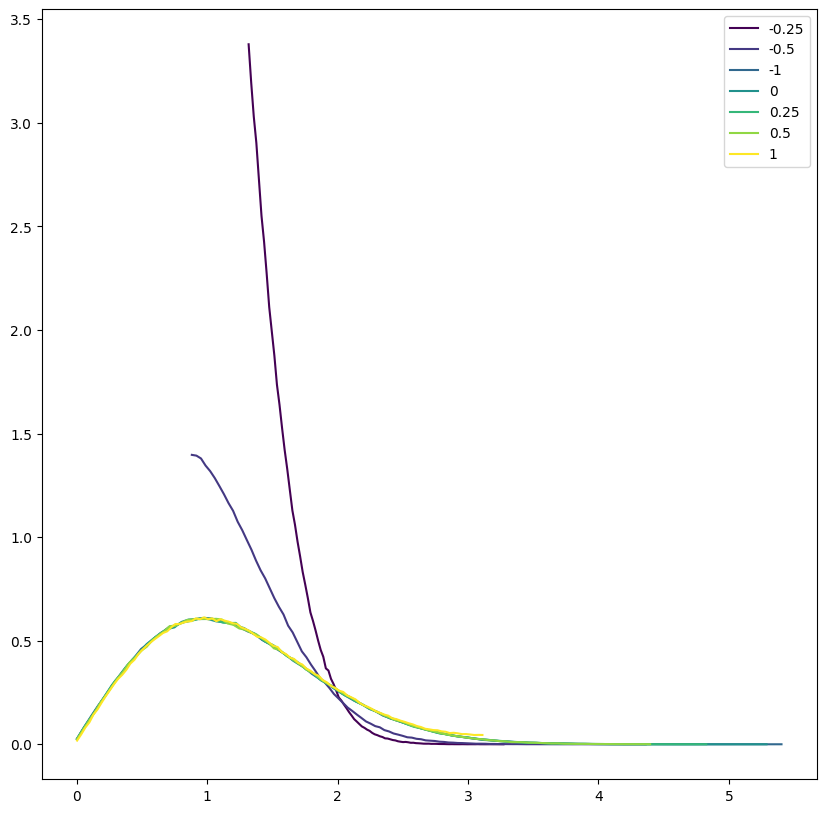

In [13]:
# Plot pdf
import matplotlib.pyplot as plt

# Use RdBu colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

fig = plt.figure(figsize=(10, 10))

for i, (curvature, dists) in enumerate(results.items()):
    # Generate line graph of pdf
    # plt.hist(
    #     dists, bins=100, density=True, alpha=0.5, label=f"{curvature}", color=colors[i]
    # )
    # Drop nans
    dists = dists[~np.isnan(dists)]
    hist = np.histogram(dists, bins=100, density=True)
    plt.plot(hist[1][:-1], hist[0], label=f"{curvature}", color=colors[i])
plt.legend()
# plt.xlim(0, 3)

In [ ]:
# K = 0 --> Euclidean
# K = 0.1 --> Spherical (radius 1/sqrt(0.1) ~ 3.16)
    # Rescale vectors to be SMALLER, i.e. multiply by sqrt(k)
# K = 1 --> Spherical (radius 1)
# K = 10 --> Spherical (radius 1/sqrt(10) ~ 0.316)
    # Rescale vectors to be LARGER, i.e. multiply by sqrt(k)

(array([3.8100e+02, 1.0550e+03, 1.7060e+03, 2.2530e+03, 2.8630e+03,
        3.4460e+03, 4.1370e+03, 4.6060e+03, 5.3640e+03, 5.8810e+03,
        6.2860e+03, 6.8620e+03, 7.4680e+03, 7.8860e+03, 8.2480e+03,
        8.5520e+03, 9.4170e+03, 9.4430e+03, 9.8140e+03, 1.0271e+04,
        1.0529e+04, 1.0946e+04, 1.1162e+04, 1.1426e+04, 1.1639e+04,
        1.1874e+04, 1.1793e+04, 1.2044e+04, 1.2234e+04, 1.2164e+04,
        1.2332e+04, 1.2058e+04, 1.2303e+04, 1.2261e+04, 1.2344e+04,
        1.2195e+04, 1.2032e+04, 1.2114e+04, 1.2049e+04, 1.2173e+04,
        1.1771e+04, 1.1600e+04, 1.1737e+04, 1.5124e+04, 1.7789e+04,
        1.7701e+04, 1.8125e+04, 1.8416e+04, 1.8708e+04, 1.8916e+04,
        1.8839e+04, 1.9327e+04, 1.9334e+04, 1.9166e+04, 1.9241e+04,
        1.9323e+04, 1.9474e+04, 1.9386e+04, 1.9318e+04, 1.9238e+04,
        1.9004e+04, 1.8708e+04, 1.8571e+04, 1.8279e+04, 1.7684e+04,
        1.7526e+04, 1.6904e+04, 1.6304e+04, 1.5601e+04, 1.4742e+04,
        1.4086e+04, 1.3416e+04, 1.2188e+04, 1.13

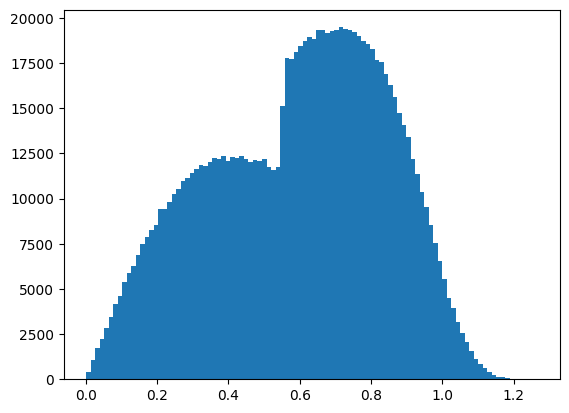

In [7]:
plt.hist(results[-1], bins=100)

In [128]:
h.metric.norm(X_manifold)

array([0.83736687, 0.86459252,        nan, ..., 0.9310507 , 0.97819941,
       0.80606044])

In [129]:
X_manifold

array([[-0.38653378, -0.65140977,  0.65288357],
       [-0.35530253,  0.20211172,  0.91263956],
       [-0.86631687, -0.48082744,  0.13527767],
       ...,
       [-0.25801607,  0.7694765 ,  0.58423764],
       [-0.14684332, -0.29954745, -0.9427133 ],
       [ 0.41848929,  0.90252204, -0.10159075]])